In [2]:
import os
import random
from pathlib import Path

import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision.datasets import ImageFolder
from torchvision import transforms
from PIL import Image

import open_clip
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# pick which 
# model you want
model_name = "ViT-B-32"
pretrained = "openai"

# this returns (model, preprocess_transforms)
model, _, preprocess = open_clip.create_model_and_transforms(model_name, pretrained=pretrained)
tokenizer = open_clip.get_tokenizer(model_name)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model.to(DEVICE)

# freeze CLIP backbone
for param in model.parameters():
    param.requires_grad = False


/home/maker/.conda/envs/appliedAI/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/maker/.conda/envs/appliedAI/lib/python3.10/site-packages/open_clip/factory.py:450: UserWarning: QuickGELU mismatch between final model config (quick_gelu=False) and pretrained tag 'openai' (quick_gelu=True).
  warnings.warn(


In [3]:
# Paths
train_dir = Path("brain-tumor-dataset/Training")
test_dir = Path("brain-tumor-dataset/Testing")

# Dataset objects
train_ds = ImageFolder(train_dir, transform=preprocess)
test_ds = ImageFolder(test_dir, transform=preprocess)

# Optionally split training further into train/val
val_size = int(0.1 * len(train_ds))
train_size = len(train_ds) - val_size
train_ds, val_ds = random_split(train_ds, [train_size, val_size])

# Class names
classes = train_ds.dataset.classes  # from ImageFolder
print("Detected classes:", classes)

# Temporary loaders just for feature extraction
batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4)


Detected classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [4]:
def extract_features(loader, model, device):
    all_features, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            feats = model.encode_image(images)
            feats = feats.cpu()  # move to CPU to save memory
            all_features.append(feats)
            all_labels.append(labels)
    return torch.cat(all_features), torch.cat(all_labels)

print("Extracting train features...")
train_feats, train_labels = extract_features(train_loader, model, DEVICE)
print("Extracting val features...")
val_feats, val_labels = extract_features(val_loader, model, DEVICE)
print("Extracting test features...")
test_feats, test_labels = extract_features(test_loader, model, DEVICE)

# Wrap them in TensorDatasets for fast training
train_cached = TensorDataset(train_feats, train_labels)
val_cached = TensorDataset(val_feats, val_labels)
test_cached = TensorDataset(test_feats, test_labels)

train_loader = DataLoader(train_cached, batch_size=64, shuffle=True)
val_loader = DataLoader(val_cached, batch_size=64, shuffle=False)
test_loader = DataLoader(test_cached, batch_size=64, shuffle=False)

print("Feature caching complete!")


Extracting train features...
Extracting val features...
Extracting test features...
Feature caching complete!


In [5]:
feature_dim = train_feats.shape[1]

classifier = nn.Sequential(
    nn.Linear(feature_dim, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, len(classes))
).to(DEVICE)


optimizer = torch.optim.AdamW(classifier.parameters(), lr=1e-4, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

num_epochs = 100
train_losses = []
val_losses = []
accuracies = []

for epoch in range(num_epochs):
    # ---- Training ----
    classifier.train()
    batch_train_losses = []

    for feats, labels in train_loader:
        feats, labels = feats.to(DEVICE), labels.to(DEVICE)
        logits = classifier(feats)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_train_losses.append(loss.item())

    avg_train_loss = np.mean(batch_train_losses)
    train_losses.append(avg_train_loss)

    # ---- Validation ----
    classifier.eval()
    batch_val_losses = []
    y_true, y_pred = [], []

    with torch.no_grad():
        for feats, labels in val_loader:
            feats, labels = feats.to(DEVICE), labels.to(DEVICE)
            logits = classifier(feats)
            loss = criterion(logits, labels)
            batch_val_losses.append(loss.item())

            preds = logits.argmax(dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    avg_val_loss = np.mean(batch_val_losses)
    val_losses.append(avg_val_loss)

    acc = accuracy_score(y_true, y_pred)
    accuracies.append(acc)

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train loss: {avg_train_loss:.4f} - "
          f"Val loss: {avg_val_loss:.4f} - "
          f"Val acc: {acc:.4f}")


Epoch 1/100 - Train loss: 0.8324 - Val loss: 0.5174 - Val acc: 0.8616
Epoch 2/100 - Train loss: 0.4925 - Val loss: 0.3719 - Val acc: 0.9019
Epoch 3/100 - Train loss: 0.3969 - Val loss: 0.3018 - Val acc: 0.9089
Epoch 4/100 - Train loss: 0.3181 - Val loss: 0.2665 - Val acc: 0.9124
Epoch 5/100 - Train loss: 0.2757 - Val loss: 0.2313 - Val acc: 0.9317
Epoch 6/100 - Train loss: 0.2446 - Val loss: 0.2103 - Val acc: 0.9317
Epoch 7/100 - Train loss: 0.2273 - Val loss: 0.1971 - Val acc: 0.9405
Epoch 8/100 - Train loss: 0.2049 - Val loss: 0.1902 - Val acc: 0.9440
Epoch 9/100 - Train loss: 0.1813 - Val loss: 0.1744 - Val acc: 0.9387
Epoch 10/100 - Train loss: 0.1709 - Val loss: 0.1693 - Val acc: 0.9405
Epoch 11/100 - Train loss: 0.1618 - Val loss: 0.1605 - Val acc: 0.9492
Epoch 12/100 - Train loss: 0.1421 - Val loss: 0.1545 - Val acc: 0.9527
Epoch 13/100 - Train loss: 0.1280 - Val loss: 0.1578 - Val acc: 0.9440
Epoch 14/100 - Train loss: 0.1248 - Val loss: 0.1489 - Val acc: 0.9510
Epoch 15/100 - 

Classification Report:
              precision    recall  f1-score   support

      glioma       0.98      0.87      0.92       300
  meningioma       0.88      0.97      0.93       306
     notumor       0.99      1.00      0.99       405
   pituitary       0.98      0.99      0.98       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



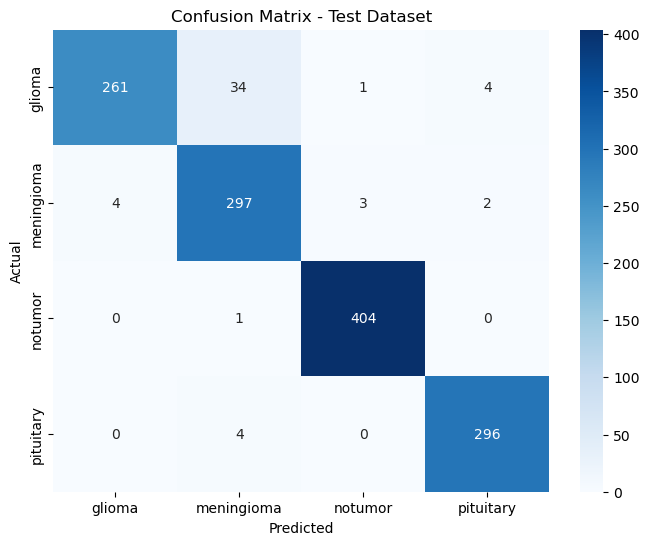

In [6]:
classifier.eval()
all_labels, all_preds = [], []

with torch.no_grad():
    for feats, labels in test_loader:
        feats, labels = feats.to(DEVICE), labels.to(DEVICE)
        logits = classifier(feats)
        preds = logits.argmax(dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=classes))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Dataset')
plt.show()


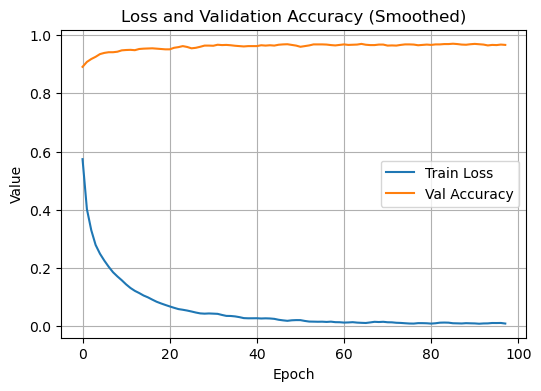

Average of last 25 epochs: 
Accuracy: 0.9673788674839463
Average loss : 0.01068743340668188


In [7]:
def smooth(data, window=3):
    """Simple moving average smoothing"""
    return np.convolve(data, np.ones(window)/window, mode='valid')

def tail_n_average(data, window=3):
    """Return the average of the last n datapoints"""
    return np.mean(data[-window:])

# Smooth the curves
smoothed_val_losses = smooth(val_losses, window=3)
smoothed_train_losses = smooth(train_losses, window=3)
smoothed_accs = smooth(accuracies, window=3)

plt.figure(figsize=(6,4))
plt.plot(smoothed_train_losses, label='Train Loss')
plt.plot(smoothed_accs, label='Val Accuracy')
#plt.plot(tail_n_average(smoothed_losses, 25), label='test')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.title('Loss and Validation Accuracy (Smoothed)')
plt.grid(True)
plt.show()

n = 25
average_acc = tail_n_average(smoothed_accs, n)
average_loss = tail_n_average(smoothed_train_losses, n)

print(f"Average of last {n} epochs: ")
print(f"Accuracy: {average_acc}")
print(f"Average loss : {average_loss}")

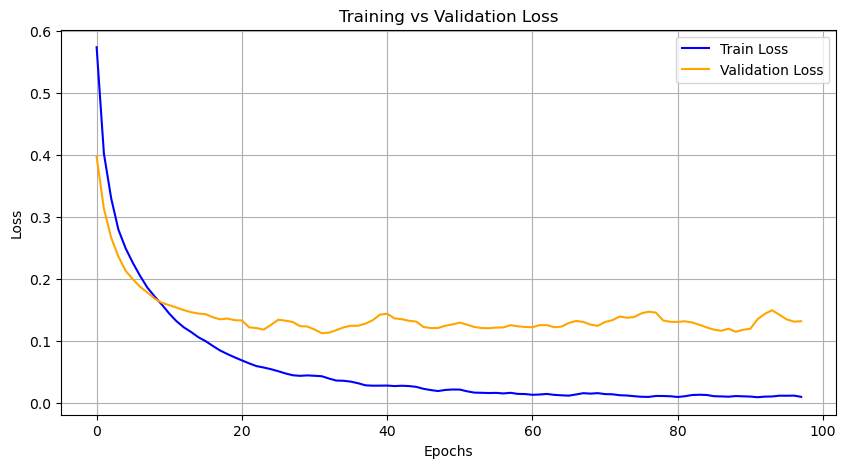

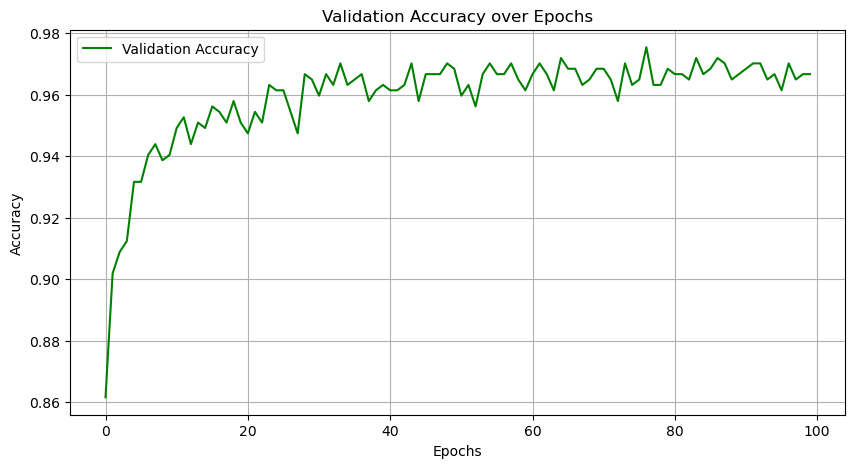

In [8]:
# Plot Training vs Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(smoothed_train_losses, label="Train Loss", color='blue')
plt.plot(smoothed_val_losses, label="Validation Loss", color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Optional: Plot Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(accuracies, label="Validation Accuracy", color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy over Epochs")
plt.legend()
plt.grid(True)
plt.show()